# Imports


In [1]:
!pip install visualkeras
!pip install xarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 12.5 MB/s eta 0:00:00


In [2]:
# Libraries
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
import visualkeras
import tensorflow
from tensorflow import keras as keras
from keras import callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model

from keras import Model, Sequential

from keras.optimizers import Adam

from keras.losses import MeanSquaredError
from keras.metrics import MeanAbsoluteError

from keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, GRU, LSTMCell
from keras.layers import Conv2D, MaxPooling2D, Flatten, Bidirectional, LSTM, Dense, TimeDistributed, Conv1D, MaxPooling1D, Dropout, Conv3D
import warnings
warnings.filterwarnings('ignore')

# Reading Dataset

In [4]:
# Alternate approach could be to mount, this one uses a google drive link to download dataset
!pip install gdown
import gdown

# Download the file from a google drive link
file_id = '1wqsx6FcNKAVjBaMdRHN5ccFOZgenUbap'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'IMDAA_merged_1.08_1990_2020.nc', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1wqsx6FcNKAVjBaMdRHN5ccFOZgenUbap
From (redirected): https://drive.google.com/uc?id=1wqsx6FcNKAVjBaMdRHN5ccFOZgenUbap&confirm=t&uuid=cb2a6d38-dc24-4e34-a266-c4c5903744c5
To: /content/IMDAA_merged_1.08_1990_2020.nc
100%|██████████| 742M/742M [00:06<00:00, 120MB/s]


'IMDAA_merged_1.08_1990_2020.nc'

In [5]:
file_path = 'IMDAA_merged_1.08_1990_2020.nc'
data=  xr.open_dataset(file_path)
data.head()

<xarray.Dataset> Size: 2kB
Dimensions:   (time: 5, latitude: 5, longitude: 5)
Coordinates:
  * time      (time) datetime64[ns] 40B 1990-01-01 ... 1990-01-02
    lat       (latitude) float64 40B ...
    lon       (longitude) float64 40B ...
Dimensions without coordinates: latitude, longitude
Data variables:
    HGT_prl   (time, latitude, longitude) float32 500B ...
    TMP_prl   (time, latitude, longitude) float32 500B ...
    TMP_2m    (time, latitude, longitude) float32 500B ...
    APCP_sfc  (time, latitude, longitude) float32 500B ...
Attributes:
    CDI:                  Climate Data Interface version 1.9.8 (https://mpime...
    Conventions:          COARDS
    history:              Wed Jun 14 21:34:08 2023: cdo -f nc4c -z zip_4 copy...
    History:              created by wgrib2
    GRIB2_grid_template:  0
    CDO:                  Climate Data Operators version 1.9.8 (https://mpime...
    regrid_method:        bilinear

# Visualize the data

In [6]:
data.attrs

{'CDI': 'Climate Data Interface version 1.9.8 (https://mpimet.mpg.de/cdi)',
 'Conventions': 'COARDS',
 'history': 'Wed Jun 14 21:34:08 2023: cdo -f nc4c -z zip_4 copy -mergetime -cat /DATA2/tmpdata/query-processed/AqoSuNR7FfLIAP0a36Fgeg/ncum_imdaa_reanl_HGT-prl_199001.nc /DATA2/tmpdata/query-processed/AqoSuNR7FfLIAP0a36Fgeg/ncum_imdaa_reanl_HGT-prl_199002.nc /DATA2/tmpdata/query-processed/AqoSuNR7FfLIAP0a36Fgeg/ncum_imdaa_reanl_HGT-prl_199003.nc /DATA2/tmpdata/query-processed/AqoSuNR7FfLIAP0a36Fgeg/ncum_imdaa_reanl_HGT-prl_199004.nc /DATA2/tmpdata/query-processed/AqoSuNR7FfLIAP0a36Fgeg/ncum_imdaa_reanl_HGT-prl_199005.nc /DATA2/tmpdata/query-processed/AqoSuNR7FfLIAP0a36Fgeg/ncum_imdaa_reanl_HGT-prl_199006.nc /DATA2/tmpdata/query-processed/AqoSuNR7FfLIAP0a36Fgeg/ncum_imdaa_reanl_HGT-prl_199007.nc /DATA2/tmpdata/query-processed/AqoSuNR7FfLIAP0a36Fgeg/ncum_imdaa_reanl_HGT-prl_199008.nc /DATA2/tmpdata/query-processed/AqoSuNR7FfLIAP0a36Fgeg/ncum_imdaa_reanl_HGT-prl_199009.nc /DATA2/tmpdata/q

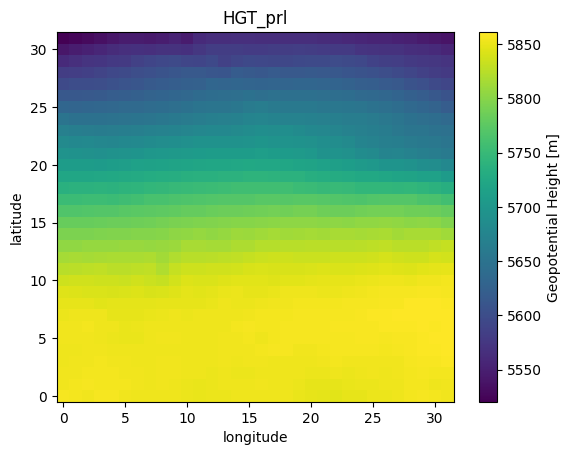

HGT_prl


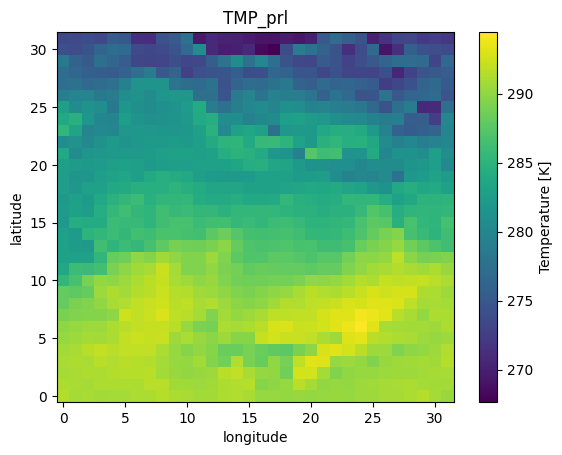

TMP_prl


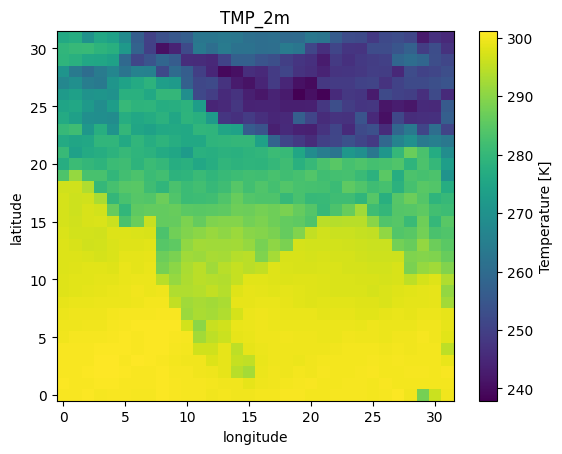

TMP_2m


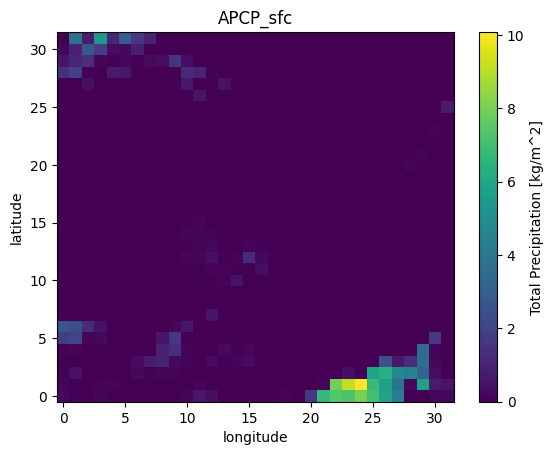

APCP_sfc


In [7]:
for var in data.data_vars:
    data[var].isel(time=0).plot()
    plt.title(var)
    plt.show()
    print(var)

# Define data and its split selection

In [8]:
var_name = ['HGT_prl', 'TMP_prl', 'TMP_2m', 'APCP_sfc'] # [H500, T850, T2m, TP6h]

In [9]:
ds = data['TMP_prl']
ds = ds.to_dataset()
ds

<xarray.Dataset> Size: 186MB
Dimensions:  (time: 45292, latitude: 32, longitude: 32)
Coordinates:
  * time     (time) datetime64[ns] 362kB 1990-01-01 ... 2020-12-31T18:00:00
    lat      (latitude) float64 256B ...
    lon      (longitude) float64 256B ...
Dimensions without coordinates: latitude, longitude
Data variables:
    TMP_prl  (time, latitude, longitude) float32 186MB ...

In [10]:
# training dataset selection
train_years = slice('1990', '2017')
# validation dataset selection (this dataset helps with overfitting)
valid_years = slice('2018', '2018')
# test dataset selection
test_years = slice('2019', '2020')
# prediction days ahead
lead_time_steps = 20 # consider the number of observations per day

# Training functions and error metrics

In [11]:
def get_train_valid_test_dataset(lead_steps, Data_array):
  # Split train, valid and test dataset
  train_data = Data_array.sel(time=train_years)
  valid_data = Data_array.sel(time=valid_years)
  test_data = Data_array.sel(time=test_years)

  # Normalize the data using the mean and standard deviation of the training data
  # mean = train_data.mean(dim = "time")
  # std = train_data.std(dim = "time")

  mean = train_data.mean()
  std = train_data.std()

  train_data = (train_data - mean) / std
  valid_data = (valid_data - mean) / std
  test_data = (test_data - mean) / std

  # Create inputs and outputs that are shifted by lead_steps
  X_train = train_data[list(Data_array)[0]].isel(time=slice(None, -lead_steps)).values[..., None]
  Y_train = train_data[list(Data_array)[0]].isel(time=slice(lead_steps, None)).values[..., None]
  X_valid = valid_data[list(Data_array)[0]].isel(time=slice(None, -lead_steps)).values[..., None]
  Y_valid = valid_data[list(Data_array)[0]].isel(time=slice(lead_steps, None)).values[..., None]
  X_test = test_data[list(Data_array)[0]].isel(time=slice(None, -lead_steps)).values[..., None]
  Y_test = test_data[list(Data_array)[0]].isel(time=slice(lead_steps, None)).values[..., None]
  return X_train, Y_train, X_valid, Y_valid, X_test, Y_test, mean, std

In [12]:
X_train, Y_train, X_valid, Y_valid, X_test, Y_test, mean, std = get_train_valid_test_dataset(lead_time_steps, ds)

In [13]:
mean

<xarray.Dataset> Size: 4B
Dimensions:  ()
Data variables:
    TMP_prl  float32 4B 291.7

In [14]:
std

<xarray.Dataset> Size: 4B
Dimensions:  ()
Data variables:
    TMP_prl  float32 4B 5.831

In [15]:
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(40888, 32, 32, 1)
(40888, 32, 32, 1)
(1440, 32, 32, 1)
(1440, 32, 32, 1)
(2904, 32, 32, 1)
(2904, 32, 32, 1)


Evaluation Metrics

In [16]:
def compute_rmse(prediction, actual,  mean_dims = ('time', 'latitude', 'longitude')):
  error = prediction - actual
  rmse = np.sqrt(((error)**2 ).mean(mean_dims))
  return rmse

In [17]:
def compute_mae(prediction, actual, mean_dims = ('time', 'latitude', 'longitude')):
    error = prediction - actual
    mae = np.abs(error).mean(mean_dims)
    return mae

In [18]:
def compute_acc(prediction, actual):
    clim = actual.mean('time')
    try:
        t = np.intersect1d(prediction.time, actual.time)
        pred_anomaly = prediction.sel(time=t) - clim
    except AttributeError:
        t = actual.time.values
        pred_anomaly = prediction - clim
    act_anomaly = actual.sel(time=t) - clim

    pred_norm = pred_anomaly - pred_anomaly.mean()
    act_norm = act_anomaly - act_anomaly.mean()

    acc = (
            np.sum(pred_norm * act_norm) /
            np.sqrt(
                np.sum(pred_norm ** 2) * np.sum(act_norm ** 2)
            )
    )
    return acc

# CNN

In [19]:
# Check the size of training, validation and testing dataset
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(40888, 32, 32, 1)
(40888, 32, 32, 1)
(1440, 32, 32, 1)
(1440, 32, 32, 1)
(2904, 32, 32, 1)
(2904, 32, 32, 1)


In [20]:
def fit_model(model):

    history = model.fit(X_train, Y_train, epochs = 10,
                        validation_data= (X_valid, Y_valid) ,
                        batch_size = 32, shuffle = False,
                        callbacks = [early_stop])
    return history

## Original Model

In [21]:
model_cnn = keras.Sequential([
    keras.layers.Conv2D(32, 5, padding='same', activation= 'swish'),
    # keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 5, padding='same', activation= 'swish'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 5, padding='same', activation= 'swish'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 5, padding='same', activation= 'swish'),
    keras.layers.MaxPooling2D(),

    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(32, 5, padding='same', activation= 'swish'),
    keras.layers.UpSampling2D(),
    keras.layers.Conv2D(32, 5, padding='same', activation= 'swish'),
    keras.layers.UpSampling2D(),
    keras.layers.Conv2D(32, 5, padding='same', activation= 'swish'),
    keras.layers.UpSampling2D(),
    keras.layers.Conv2D(32, 5, padding='same', activation= 'swish'),
    keras.layers.UpSampling2D(),
    # keras.layers.BatchNormalization(),

    keras.layers.Conv2D(1, 5, padding='same'),

    # No activation since we are solving a regression problem
])

In [22]:
model_cnn.build(X_train[:32].shape)
model_cnn.compile(keras.optimizers.Adam(learning_rate=1e-5), 'mse')
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (32, 32, 32, 32)            │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 16, 16, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 16, 16, 32)            │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 8, 8, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 8, 8, 32)              │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 4, 4, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 4, 4, 32)              │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 2, 2, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (32, 2, 2, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 2, 2, 32)              │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (32, 4, 4, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 32)              │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (32, 8, 8, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (32, 8, 8, 32)              │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (32, 16, 16, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (32, 16, 16, 32)            │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (32, 32, 32, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (32, 32, 32, 1)             │             801 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 181,057 (707.25 KB)

 Trainable params: 181,057 (707.25 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
#create callback
filepath = 'IMDAA_CNN_H500_5days.keras'

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

In [24]:
early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, verbose=1)
history_cnn = fit_model(model_cnn)

Epoch 1/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - loss: 0.7592 - val_loss: 0.3086
Epoch 2/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3036 - val_loss: 0.2464
Epoch 3/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2570 - val_loss: 0.2265
Epoch 4/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.2414 - val_loss: 0.2155
Epoch 5/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2325 - val_loss: 0.2084
Epoch 6/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2260 - val_loss: 0.2032
Epoch 7/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2209 - val_loss: 0.1988
Epoch 8/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2167 - val_loss: 0.1954
Epoch 9/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.2131 - val_loss: 0.1927
Epoch 10/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.2107 - val_loss: 0.1906


In [25]:
# save the model
model_cnn.save('IMDAA_CNN_T850_5days_val_loss_0.1473.keras')

Values stored in history are ... 
 {'loss': [0.5335132479667664, 0.28367313742637634, 0.2498438060283661, 0.2362181693315506, 0.22791330516338348, 0.22193259000778198, 0.2170669287443161, 0.21275091171264648, 0.20952916145324707, 0.20722737908363342], 'val_loss': [0.30857911705970764, 0.24640154838562012, 0.22649487853050232, 0.21554285287857056, 0.2083956003189087, 0.2032293677330017, 0.19883421063423157, 0.1953784078359604, 0.19272221624851227, 0.19057074189186096]}


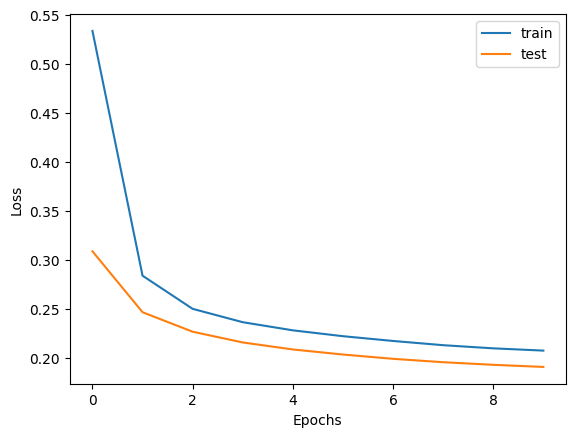

In [26]:
# plot training history
print("Values stored in history are ... \n", history_cnn.history)
plt.plot(history_cnn.history['loss'], label='train')
plt.plot(history_cnn.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Visualization of Model

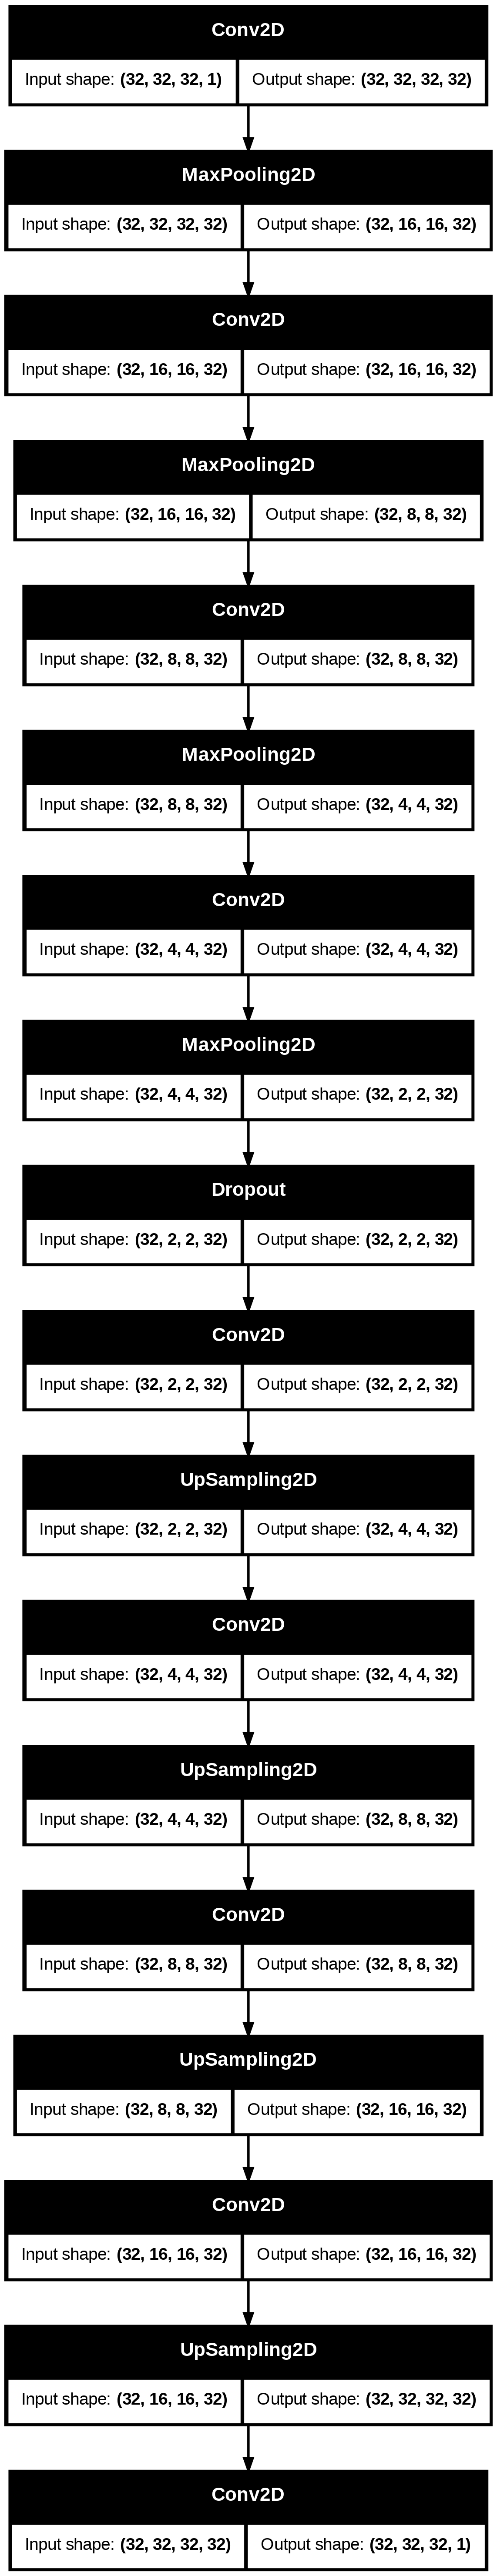

In [27]:
# Visualize the architecture of the CNN
# tf.keras.utils.plot_model(model, to_file= "CNN_IMDAA.png", show_shapes=True)
# Visualize the architecture of the CNN
keras.utils.plot_model(model_cnn, show_shapes=True)

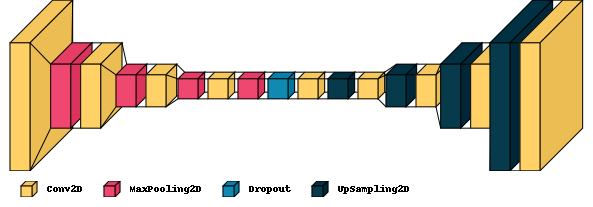

In [28]:
visualkeras.layered_view(model_cnn, legend=True, draw_volume = 2)

## Evaluation of the Original Model

In [29]:
target = ds.sel(time=test_years)
# Convert predictions backto xarray
pred_test = X_test[:, :, :, 0].copy()
pred_test[:] = model_cnn.predict(X_test).squeeze()

# Unnormalize
pred_result = pred_test*std.TMP_prl.values + mean.TMP_prl.values
pred_result  = xr.DataArray(pred_result, dims=target.isel(time=slice(lead_time_steps, None)).dims, coords=target.isel(time=slice(lead_time_steps, None)).coords)
# compute RMSE
print('RMSE:', compute_rmse(pred_result, target.isel(time=slice(lead_time_steps, None))).TMP_prl.values)
print('MAE', compute_mae(pred_result, target.isel(time=slice(lead_time_steps, None))).TMP_prl.values)
print('ACC', compute_acc(pred_result, target.isel(time=slice(lead_time_steps, None))).TMP_prl.values)

91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
RMSE: 2.570925
MAE 1.8076738
ACC 0.88878334


## Comparison of the performance of different activation types

In [30]:
def build_model(activation):
  model_cnn_new = keras.Sequential([
      keras.layers.Conv2D(32, 5, padding='same', activation= activation),
      keras.layers.MaxPooling2D(),
      keras.layers.Conv2D(32, 5, padding='same', activation= activation),
      keras.layers.MaxPooling2D(),
      keras.layers.Conv2D(32, 5, padding='same', activation= activation),
      keras.layers.MaxPooling2D(),
      keras.layers.Conv2D(32, 5, padding='same', activation= activation),
      keras.layers.MaxPooling2D(),

      keras.layers.Dropout(0.2),

      keras.layers.Conv2D(32, 5, padding='same', activation= activation),
      keras.layers.UpSampling2D(),
      keras.layers.Conv2D(32, 5, padding='same', activation= activation),
      keras.layers.UpSampling2D(),
      keras.layers.Conv2D(32, 5, padding='same', activation= activation),
      keras.layers.UpSampling2D(),
      keras.layers.Conv2D(32, 5, padding='same', activation= activation),
      keras.layers.UpSampling2D(),

      keras.layers.Conv2D(1, 5, padding='same'),

      # No activation since we are solving a regression problem
  ])
  return model_cnn_new

In [31]:
def test_model(activation):
  model_cnn_new = build_model(activation)
  model_cnn_new.build(X_train[:32].shape)
  model_cnn_new.compile(keras.optimizers.Adam(learning_rate=1e-5), 'mse')

  history_cnn_new = fit_model(model_cnn_new)


  # Evaluation

  target = ds.sel(time=test_years)
  # Convert predictions backto xarray
  pred_test = X_test[:, :, :, 0].copy()
  pred_test[:] = model_cnn_new.predict(X_test).squeeze()

  # Unnormalize
  pred_result_new = pred_test*std.TMP_prl.values + mean.TMP_prl.values
  pred_result_new  = xr.DataArray(pred_result_new, dims=target.isel(time=slice(lead_time_steps, None)).dims, coords=target.isel(time=slice(lead_time_steps, None)).coords)
  # compute RMSE
  return pred_result_new
  # model_cnn_new.summary()

In [32]:
# Comparison of CNN model's behaviour with different activation types
keras_conv2d_activations = [
    'relu',
    'sigmoid',
    'softmax',
    'softplus',
    'softsign',
    'tanh',
    'selu',
    'elu',
    'exponential',
    'leaky_relu',
    'relu6',
    'silu',
    'hard_silu',
    'gelu',
    'hard_sigmoid',
    'linear',
    'mish',
    'log_softmax',
    'swish',
    'hard_swish'
]
# Stores model performance for our final comparison
lowest_rmse = (100,"")
lowest_mae = (100,"")
highest_acc = (0,"")
target = ds.sel(time=test_years)
early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, verbose=1)
for activation in keras_conv2d_activations:
  print("##########     "+activation+"        ##############")
  pred_result_new = test_model(activation)
  print("##########     "+activation+"        ##############")
  rmse = compute_rmse(pred_result_new, target.isel(time=slice(lead_time_steps, None))).TMP_prl.values
  mae = compute_mae(pred_result_new, target.isel(time=slice(lead_time_steps, None))).TMP_prl.values
  acc = compute_acc(pred_result_new, target.isel(time=slice(lead_time_steps, None))).TMP_prl.values
  print("RMSE:", rmse)
  print("MAE", mae)
  print("ACC", acc)
  if(rmse < lowest_rmse[0]):
    lowest_rmse = (rmse,activation)
  if(mae < lowest_mae[0]):
    lowest_mae = (mae,activation)
  if(acc > highest_acc[0]):
    highest_acc = (acc,activation)

print("Best models for each metric:")
print(f"RMSE: {lowest_rmse}")
print(f"MAE: {lowest_mae}")
print(f"ACC: {highest_acc}")

##########     relu        ##############
Epoch 1/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.8046 - val_loss: 0.2503
Epoch 2/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2666 - val_loss: 0.2065
Epoch 3/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2335 - val_loss: 0.1952
Epoch 4/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.2218 - val_loss: 0.1895
Epoch 5/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2150 - val_loss: 0.1855
Epoch 6/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2102 - val_loss: 0.1820
Epoch 7/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2062 - val_loss: 0.1793
Epoch 8/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.2033 - val_loss: 0.1774
Epoch 9/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.2012 - val_loss: 0.1754
Epoch 10/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1990 - val_loss: 0.1747
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
##########     relu        ########

## New Model

In [33]:
# Choosing activation selu due to performance
model_cnn_new = keras.Sequential([
      # Layer 1: filter size = 10, number of filters = 128
      keras.layers.Conv2D(512, 10, padding='same', activation= 'selu'),
      keras.layers.MaxPooling2D(),
      # Layer 2: filter size = 5, number of filters = 32
      keras.layers.Conv2D(64, 5, padding='same', activation= 'selu'),
      keras.layers.MaxPooling2D(),
      # Layer 3: filter size = 5, number of filters = 64
      keras.layers.Conv2D(128, 8, padding='same', activation= 'selu'),
      keras.layers.MaxPooling2D(),
      # # Layer 4: filter size = 10, number of filters = 32
      # keras.layers.Conv2D(32, 10, padding='same', activation= 'selu'),
      # keras.layers.MaxPooling2D(),

      keras.layers.Dropout(0.3),

      # keras.layers.Conv2D(32, 10, padding='same', activation= 'selu'),
      # keras.layers.UpSampling2D(),
      keras.layers.Conv2D(32, 5, padding='same', activation= 'selu'),
      keras.layers.UpSampling2D(),
      keras.layers.Conv2D(32, 5, padding='same', activation= 'selu'),
      keras.layers.UpSampling2D(),
      keras.layers.Conv2D(32, 5, padding='same', activation= 'selu'),
      keras.layers.UpSampling2D(),

      keras.layers.Conv2D(1, 5, padding='same'),

      # No activation since we are solving a regression problem
  ])

In [34]:
model_cnn_new.build(X_train[:32].shape)
model_cnn_new.compile(keras.optimizers.Adam(learning_rate=1e-4), 'mse')
model_cnn_new.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_189 (Conv2D)                  │ (32, 32, 32, 512)           │          51,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_84 (MaxPooling2D)      │ (32, 16, 16, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_190 (Conv2D)                  │ (32, 16, 16, 64)            │         819,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_85 (MaxPooling2D)      │ (32, 8, 8, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_191 (Conv2D)                  │ (32, 8, 8, 128)             │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_86 (MaxPooling2D)      │ (32, 4, 4, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (32, 4, 4, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_192 (Conv2D)                  │ (32, 4, 4, 32)              │         102,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_84 (UpSampling2D)      │ (32, 8, 8, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_193 (Conv2D)                  │ (32, 8, 8, 32)              │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_85 (UpSampling2D)      │ (32, 16, 16, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_194 (Conv2D)                  │ (32, 16, 16, 32)            │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_86 (UpSampling2D)      │ (32, 32, 32, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_195 (Conv2D)                  │ (32, 32, 32, 1)             │             801 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,549,889 (5.91 MB)

 Trainable params: 1,549,889 (5.91 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
#create callback
filepath = 'IMDAA_CNN_H500_5days_new.keras'

In [36]:
checkpoint_new = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

In [37]:
early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, verbose=1)
history_cnn_new = fit_model(model_cnn_new)

Epoch 1/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 30s 20ms/step - loss: 0.3350 - val_loss: 0.4706
Epoch 2/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - loss: 0.2422 - val_loss: 0.1850
Epoch 3/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 0.1961 - val_loss: 0.1890
Epoch 4/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - loss: 0.1860 - val_loss: 0.1703
Epoch 5/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 0.1796 - val_loss: 0.1813
Epoch 6/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - loss: 0.1756 - val_loss: 0.1653
Epoch 7/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 0.1712 - val_loss: 0.1574
Epoch 8/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 0.1679 - val_loss: 0.1581
Epoch 9/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - loss: 0.1636 - val_loss: 0.1551
Epoch 10/10
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - loss: 0.1603 - val_loss: 0.1569


In [38]:
# save the model
model_cnn_new.save('IMDAA_CNN_T850_5days_val_loss_0.1473_new.keras')

Values stored in history are ... 
 {'loss': [0.2952318787574768, 0.22554002702236176, 0.19446036219596863, 0.18343815207481384, 0.17820684611797333, 0.17313575744628906, 0.16891741752624512, 0.16609832644462585, 0.16231085360050201, 0.15874145925045013], 'val_loss': [0.47056692838668823, 0.18498705327510834, 0.18895018100738525, 0.17028170824050903, 0.18133994936943054, 0.1653471738100052, 0.15739156305789948, 0.15814097225666046, 0.15510398149490356, 0.15690229833126068]}


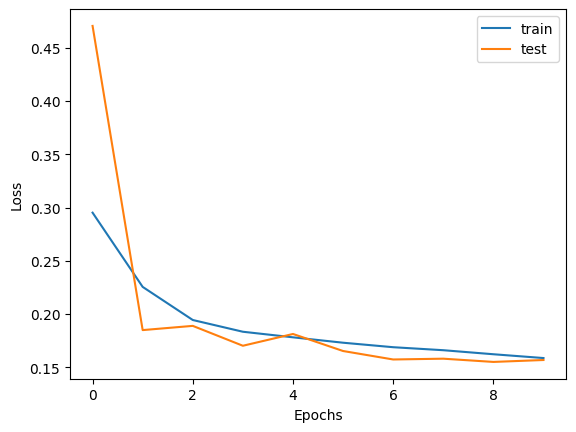

In [39]:
# plot training history
print("Values stored in history are ... \n", history_cnn_new.history)
plt.plot(history_cnn_new.history['loss'], label='train')
plt.plot(history_cnn_new.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

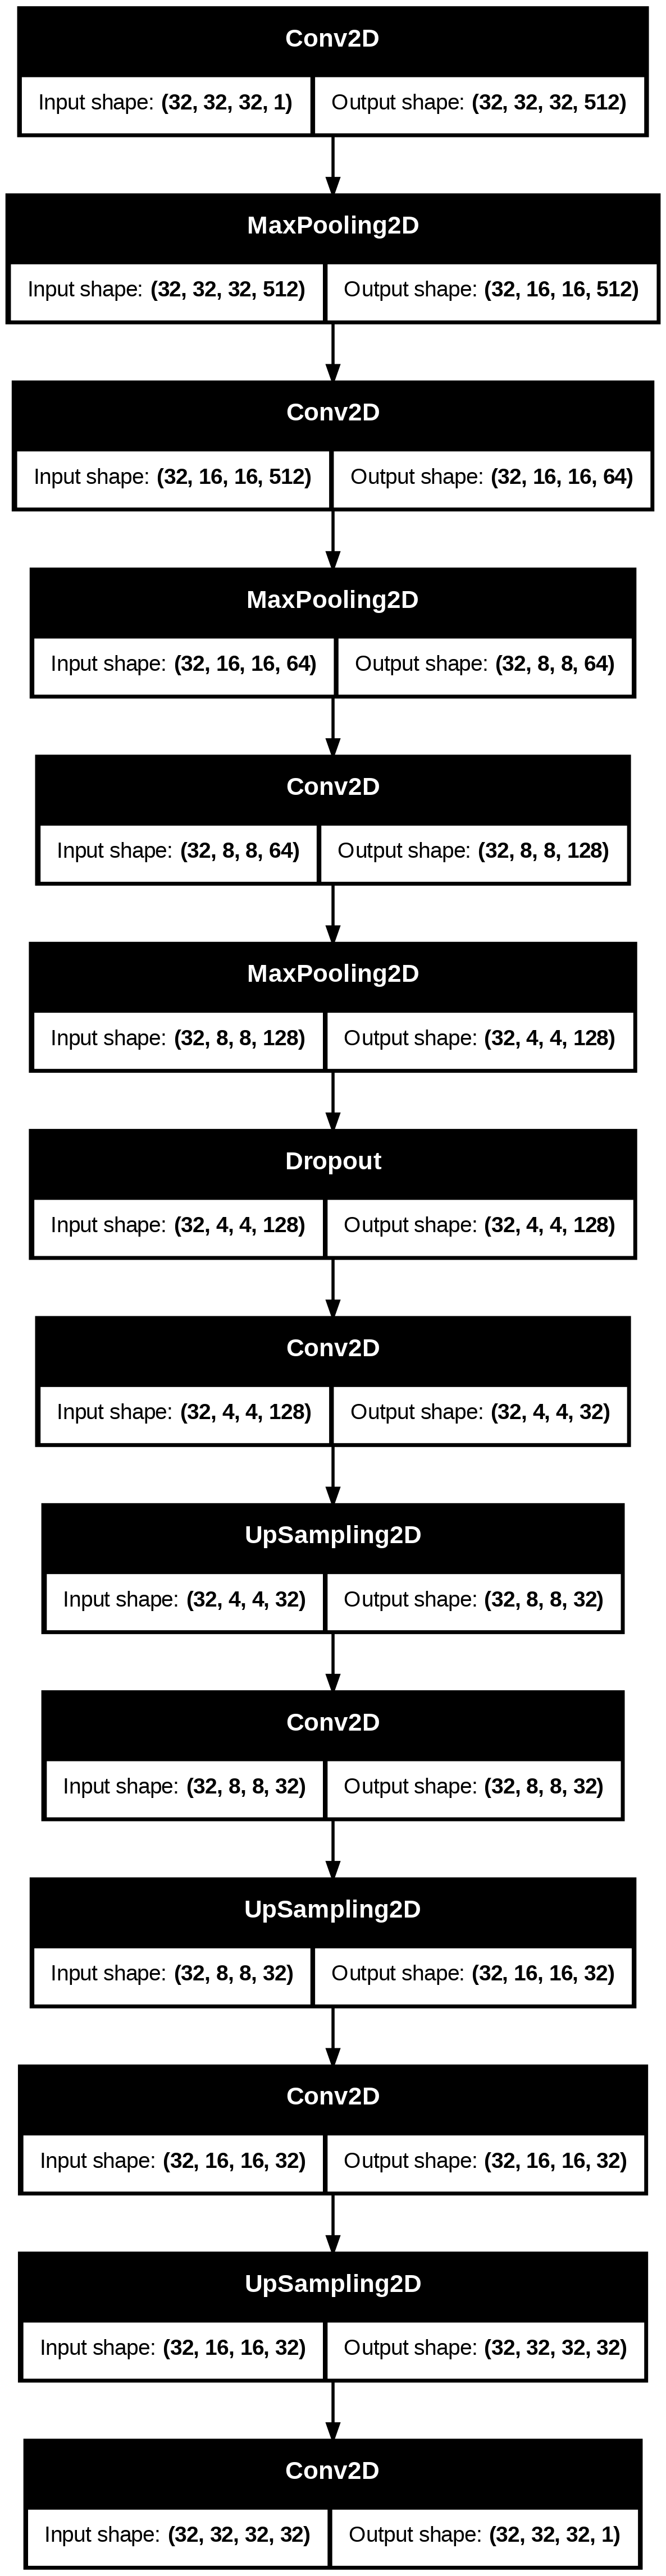

In [40]:
# Visualize the architecture of the CNN
keras.utils.plot_model(model_cnn_new, show_shapes=True)

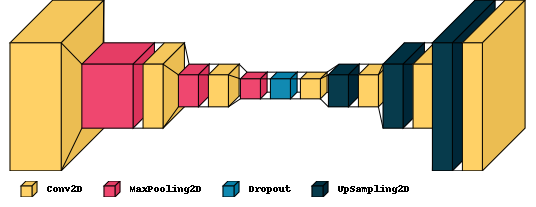

In [41]:
visualkeras.layered_view(model_cnn_new, legend=True, draw_volume = 2)

## Evaluation of New Model

In [42]:
target = ds.sel(time=test_years)
# Convert predictions backto xarray
pred_test = X_test[:, :, :, 0].copy()
pred_test[:] = model_cnn_new.predict(X_test).squeeze()

# Unnormalize
pred_result = pred_test*std.TMP_prl.values + mean.TMP_prl.values
pred_result  = xr.DataArray(pred_result, dims=target.isel(time=slice(lead_time_steps, None)).dims, coords=target.isel(time=slice(lead_time_steps, None)).coords)
# compute RMSE
print('RMSE:', compute_rmse(pred_result, target.isel(time=slice(lead_time_steps, None))).TMP_prl.values)
print('MAE', compute_mae(pred_result, target.isel(time=slice(lead_time_steps, None))).TMP_prl.values)
print('ACC', compute_acc(pred_result, target.isel(time=slice(lead_time_steps, None))).TMP_prl.values)

91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
RMSE: 2.4088113
MAE 1.6853497
ACC 0.90954936


# convLSTM

In [43]:
X_train = X_train[:, np.newaxis,:,:,:]
Y_train = Y_train[:, np.newaxis,:,:,:]
X_valid = X_valid[:, np.newaxis,:,:,:]
Y_valid = Y_valid[:, np.newaxis,:,:,:]
X_test = X_test[:, np.newaxis,:,:,:]
Y_test = Y_test[:, np.newaxis,:,:,:]

In [44]:
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(40888, 1, 32, 32, 1)
(40888, 1, 32, 32, 1)
(1440, 1, 32, 32, 1)
(1440, 1, 32, 32, 1)
(2904, 1, 32, 32, 1)
(2904, 1, 32, 32, 1)


## Original convLSTM

In [45]:
# Build an convLSTM network
model = keras.Sequential([
    # keras.layers.ConvLSTM2D(filters=32, kernel_size=(5, 5), padding="same", return_sequences=True, activation= 'swish'),
    # keras.layers.MaxPooling3D(pool_size=(1, 2, 2)),
    # keras.layers.ConvLSTM2D(filters=32, kernel_size=(5, 5), padding="same", return_sequences=True, activation= 'swish'),
    # keras.layers.MaxPooling3D(pool_size=(1, 2, 2)),
    keras.layers.ConvLSTM2D(filters=32, kernel_size=(5, 5), padding="same", return_sequences=True, activation= 'swish'),
    keras.layers.MaxPooling3D(pool_size=(1, 2, 2)),
    keras.layers.ConvLSTM2D(filters=32, kernel_size=(5, 5), padding="same", return_sequences=True, activation= 'swish'),
    keras.layers.MaxPooling3D(pool_size=(1, 2, 2)),
    keras.layers.Dropout(0.2),
    keras.layers.ConvLSTM2D(filters=32, kernel_size=(5, 5), padding="same", return_sequences=True, activation= 'swish'),
    keras.layers.UpSampling3D(size=(1, 2, 2)),
    keras.layers.ConvLSTM2D(filters=32, kernel_size=(5, 5), padding="same", return_sequences=True, activation= 'swish'),
    keras.layers.UpSampling3D(size=(1, 2, 2)),
    # keras.layers.ConvLSTM2D(filters=32, kernel_size=(5, 5), padding="same", return_sequences=True, activation= 'swish'),
    # keras.layers.UpSampling3D(size=(1, 2, 2)),
    # keras.layers.ConvLSTM2D(filters=32, kernel_size=(5, 5), padding="same", return_sequences=True, activation= 'swish'),
    # keras.layers.UpSampling3D(size=(1, 2, 2)),

    keras.layers.Conv3D(filters=1, kernel_size=(5, 5, 5),  padding="same")
])

In [46]:
model.build((None, 1, 32, 32,  1))
model.compile(keras.optimizers.Adam(learning_rate=1e-6), 'mse')
model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)             │ (None, 1, 32, 32, 32)       │         105,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 1, 16, 16, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)           │ (None, 1, 16, 16, 32)       │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 1, 8, 8, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 1, 8, 8, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)           │ (None, 1, 8, 8, 32)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling3d (UpSampling3D)         │ (None, 1, 16, 16, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)           │ (None, 1, 16, 16, 32)       │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling3d_1 (UpSampling3D)       │ (None, 1, 32, 32, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d (Conv3D)                      │ (None, 1, 32, 32, 1)        │           4,001 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 724,513 (2.76 MB)

 Trainable params: 724,513 (2.76 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#create callback
filepath = 'IMDAA_convlstm_H500_3days.keras'
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 3, verbose=1)

In [48]:
early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, verbose=1)
def fit_model(model):

    history = model.fit(X_train, Y_train, epochs = 5,
                        validation_data= (X_valid, Y_valid) ,
                        batch_size = 32, shuffle = False,
                        callbacks = [early_stop])
    return history
history_cnn = fit_model(model)

Epoch 1/5
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 42s 23ms/step - loss: 1.0213 - val_loss: 0.9450
Epoch 2/5
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - loss: 1.0213 - val_loss: 0.9450
Epoch 3/5
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - loss: 1.0213 - val_loss: 0.9449
Epoch 4/5
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - loss: 1.0212 - val_loss: 0.9446
Epoch 5/5
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - loss: 1.0207 - val_loss: 0.9437


In [50]:
model.save('IMDAA_convlstm_T850_5days_val_loss_0.1728.keras')

In [51]:
from keras.models import Sequential, load_model
model = load_model('IMDAA_convlstm_T850_5days_val_loss_0.1728.keras')

Evaluating Original convLSTM

In [52]:
target = ds.sel(time=test_years)

pred_test = model.predict(X_test).squeeze()

# Unnormalize
pred_result = pred_test*std.TMP_prl.values + mean.TMP_prl.values
pred_result  = xr.DataArray(pred_result, dims=target.isel(time=slice(lead_time_steps, None)).dims, coords=target.isel(time=slice(lead_time_steps, None)).coords)
# compute RMSE
print('RMSE:', compute_rmse(pred_result, target.isel(time=slice(lead_time_steps, None))).TMP_prl.values)
print('MAE', compute_mae(pred_result, target.isel(time=slice(lead_time_steps, None))).TMP_prl.values)
print('ACC', compute_acc(pred_result, target.isel(time=slice(lead_time_steps, None))).TMP_prl.values)

91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step
RMSE: 5.891442
MAE 4.0300407
ACC 0.0024016837


## Modified convLSTM

In [53]:
# Build an convLSTM network
model_conv_lstm = keras.Sequential([
    keras.layers.ConvLSTM2D(filters=128, kernel_size=(5, 5), padding="same", return_sequences=True, activation= 'selu'),
    keras.layers.MaxPooling3D(pool_size=(1, 2, 2)),
    keras.layers.ConvLSTM2D(filters=128, kernel_size=(5, 5), padding="same", return_sequences=True, activation= 'selu'),
    keras.layers.MaxPooling3D(pool_size=(1, 2, 2)),
    keras.layers.ConvLSTM2D(filters=128, kernel_size=(5, 5), padding="same", return_sequences=True, activation= 'selu'),
    keras.layers.MaxPooling3D(pool_size=(1, 2, 2)),
    # keras.layers.ConvLSTM2D(filters=32, kernel_size=(5, 5), padding="same", return_sequences=True, activation= 'selu'),
    # keras.layers.MaxPooling3D(pool_size=(1, 2, 2)),
    keras.layers.Dropout(0.3),
    # keras.layers.ConvLSTM2D(filters=32, kernel_size=(5, 5), padding="same", return_sequences=True, activation= 'selu'),
    # keras.layers.UpSampling3D(size=(1, 2, 2)),
    keras.layers.ConvLSTM2D(filters=32, kernel_size=(5, 5), padding="same", return_sequences=True, activation= 'selu'),
    keras.layers.UpSampling3D(size=(1, 2, 2)),
    keras.layers.ConvLSTM2D(filters=32, kernel_size=(5, 5), padding="same", return_sequences=True, activation= 'selu'),
    keras.layers.UpSampling3D(size=(1, 2, 2)),
    keras.layers.ConvLSTM2D(filters=32, kernel_size=(5, 5), padding="same", return_sequences=True, activation= 'selu'),
    keras.layers.UpSampling3D(size=(1, 2, 2)),

    keras.layers.Conv3D(filters=1, kernel_size=(5, 5, 5),  padding="same")
])

In [54]:
model_conv_lstm.build((None, 1, 32, 32,  1))
model_conv_lstm.compile(keras.optimizers.Adam(learning_rate=1e-4), 'mse')
model_conv_lstm.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d_4 (ConvLSTM2D)           │ (None, 1, 32, 32, 128)      │       1,651,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 1, 16, 16, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_5 (ConvLSTM2D)           │ (None, 1, 16, 16, 128)      │       3,277,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 1, 8, 8, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_6 (ConvLSTM2D)           │ (None, 1, 8, 8, 128)        │       3,277,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_4 (MaxPooling3D)       │ (None, 1, 4, 4, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 1, 4, 4, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_7 (ConvLSTM2D)           │ (None, 1, 4, 4, 32)         │         512,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling3d_2 (UpSampling3D)       │ (None, 1, 8, 8, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_8 (ConvLSTM2D)           │ (None, 1, 8, 8, 32)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling3d_3 (UpSampling3D)       │ (None, 1, 16, 16, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_9 (ConvLSTM2D)           │ (None, 1, 16, 16, 32)       │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling3d_4 (UpSampling3D)       │ (None, 1, 32, 32, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 1, 32, 32, 1)        │           4,001 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,132,321 (34.84 MB)

 Trainable params: 9,132,321 (34.84 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
#create callback
filepath = 'IMDAA_convlstm_H500_3days.keras'
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

In [56]:
early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, verbose=1)
def fit_model(model):

    history = model.fit(X_train, Y_train, epochs = 1,
                        validation_data= (X_valid, Y_valid) ,
                        batch_size = 32, shuffle = False,
                        callbacks = [early_stop])
    return history
history_conv_lstm = fit_model(model_conv_lstm)

1278/1278 ━━━━━━━━━━━━━━━━━━━━ 102s 66ms/step - loss: 0.4492 - val_loss: 0.2456


In [57]:
model_conv_lstm.save('IMDAA_convlstm_T850_5days_val_loss_0.1728.keras')

In [58]:
model_conv_lstm = load_model('IMDAA_convlstm_T850_5days_val_loss_0.1728.keras')

## Evaluating Modified convLSTM

In [59]:
target = ds.sel(time=test_years)

pred_test = model_conv_lstm.predict(X_test).squeeze()

# Unnormalize
pred_result = pred_test*std.TMP_prl.values + mean.TMP_prl.values
pred_result  = xr.DataArray(pred_result, dims=target.isel(time=slice(lead_time_steps, None)).dims, coords=target.isel(time=slice(lead_time_steps, None)).coords)
# compute RMSE
print('RMSE:', compute_rmse(pred_result, target.isel(time=slice(lead_time_steps, None))).TMP_prl.values)
print('MAE', compute_mae(pred_result, target.isel(time=slice(lead_time_steps, None))).TMP_prl.values)
print('ACC', compute_acc(pred_result, target.isel(time=slice(lead_time_steps, None))).TMP_prl.values)

91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step
RMSE: 2.9125454
MAE 2.0512767
ACC 0.8685186


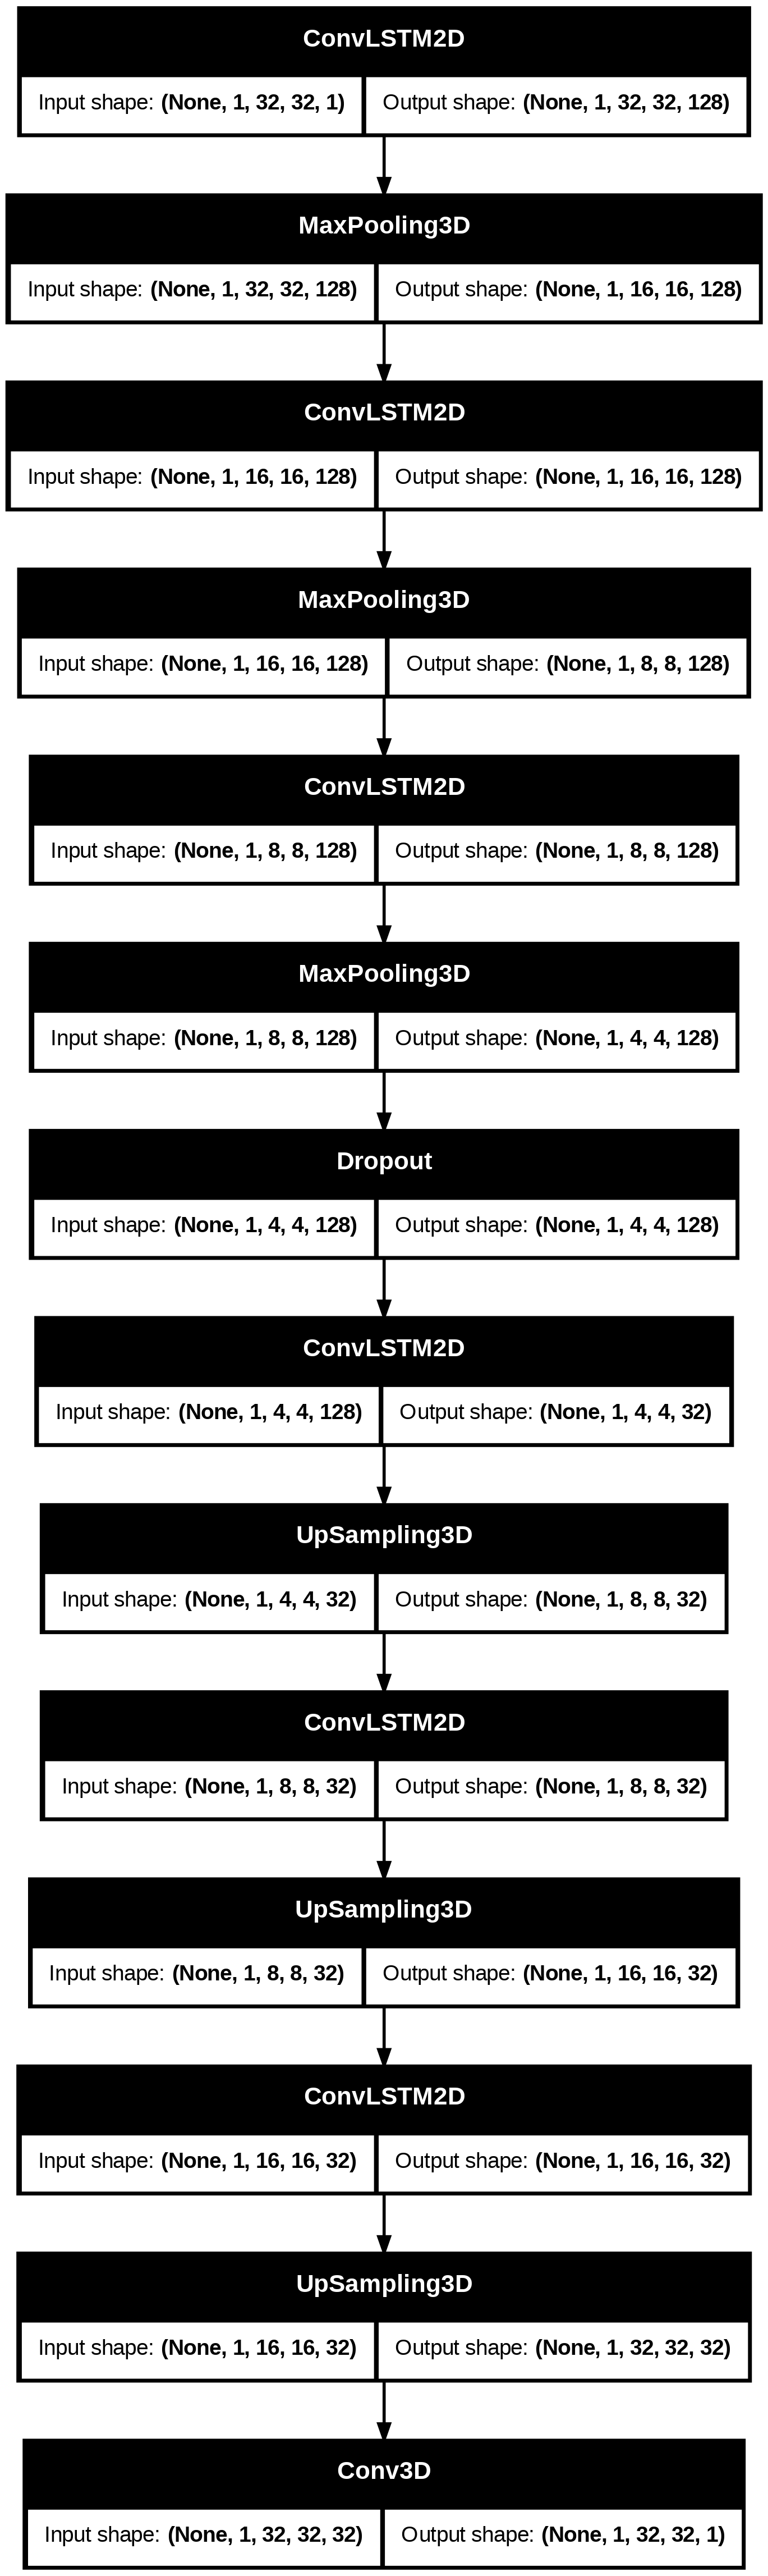

In [60]:
keras.utils.plot_model(model_conv_lstm, show_shapes=True)

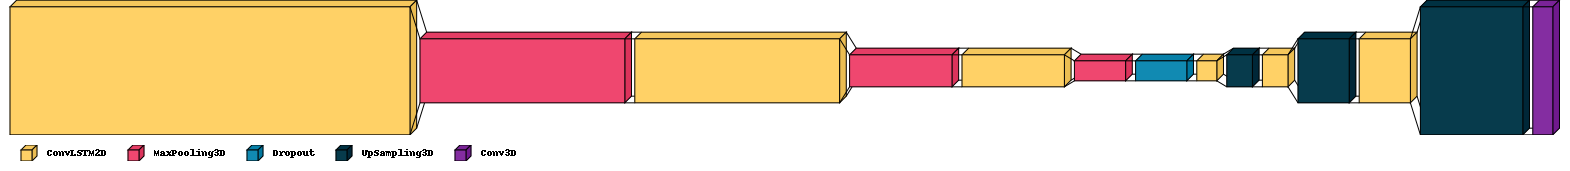

In [61]:
visualkeras.layered_view(model_conv_lstm, legend=True, draw_volume = 3)